In [40]:
%load_ext autoreload
%autoreload 2
import gym
from gym import spaces
import numpy as np
from gym_examples.envs.dubins_car import DubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
#generate data

env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(50000):
    state = env.reset()
    for action in range(env.action_space.n):
        X.append(state)
        r = env.sample(state, action, 0)
        y.append(r)

X = np.array(X)
y = np.array(y)



In [50]:
X_train = X# (X - X.mean())/(X.std())
X_train

array([[-2.8697095 ,  1.7907246 ,  3.0386097 ],
       [-2.8697095 ,  1.7907246 ,  3.0386097 ],
       [-2.8697095 ,  1.7907246 ,  3.0386097 ],
       ...,
       [ 0.15116888, -1.1916314 , -1.6643363 ],
       [ 0.15116888, -1.1916314 , -1.6643363 ],
       [ 0.15116888, -1.1916314 , -1.6643363 ]], dtype=float32)

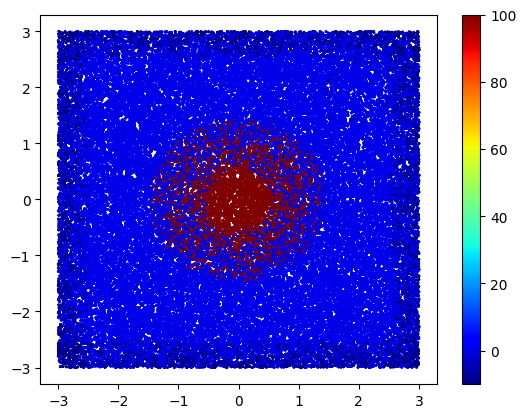

In [51]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Plot...
plt.scatter(X_train[:,0], X_train[:,1], c=y, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
#plt.show()
plt.savefig('env.png')

In [5]:
print(len(X))
print(len(y))

30000
30000


In [6]:
print(len(X_train))
print(y)
print(X_train)

30000
[-10 -10   0 ...   0   0   0]
[[-4.8275223 -0.7761065 -2.3991106]
 [-4.8275223 -0.7761065 -2.3991106]
 [-4.8275223 -0.7761065 -2.3991106]
 ...
 [-3.7414603  1.9618568  2.0530303]
 [-3.7414603  1.9618568  2.0530303]
 [-3.7414603  1.9618568  2.0530303]]


In [7]:
X

array([[-4.8275223, -0.7761065, -2.3991106],
       [-4.8275223, -0.7761065, -2.3991106],
       [-4.8275223, -0.7761065, -2.3991106],
       ...,
       [-3.7414603,  1.9618568,  2.0530303],
       [-3.7414603,  1.9618568,  2.0530303],
       [-3.7414603,  1.9618568,  2.0530303]], dtype=float32)

In [80]:
#params are defined *implicitly* in haiku
def forward(X):
    l1 = hk.Linear(9)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(1)(l2)

    return l3.ravel()

# def forward(X):

#     mlp = hk.nets.MLP(output_sizes=[3,1])
#     return mlp(X)

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X_train)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse



optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)
batch_size = len(X)//4

#check we aren't double using gradients
opt_state = optimizer.init(params)
for epoch in range(20):
    for batch in range(0,len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = env.sample_value_iter(X_batch, forward, params, gamma=0.99)
    
        loss, grads = jax.value_and_grad(loss_fn)(params,X=X_batch,y=y_batch)
        print("progress:", "epoch:", epoch, "loss",loss)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        
    
    
# After training
print("estimation of the parameters:")
print(params)

estimate  = forward(X=env.reset(), params=params)
print("estimate", estimate)

progress: epoch: 0 loss 1164.276
progress: epoch: 0 loss 1152.835
progress: epoch: 0 loss 1157.2501
progress: epoch: 0 loss 1108.8958
progress: epoch: 1 loss 1164.1371
progress: epoch: 1 loss 1152.7014
progress: epoch: 1 loss 1157.1185
progress: epoch: 1 loss 1108.7642
progress: epoch: 2 loss 1163.9972
progress: epoch: 2 loss 1152.567
progress: epoch: 2 loss 1156.9862
progress: epoch: 2 loss 1108.632
progress: epoch: 3 loss 1163.8567
progress: epoch: 3 loss 1152.4324
progress: epoch: 3 loss 1156.8536
progress: epoch: 3 loss 1108.4995
progress: epoch: 4 loss 1163.7155
progress: epoch: 4 loss 1152.2976
progress: epoch: 4 loss 1156.7205
progress: epoch: 4 loss 1108.3663
progress: epoch: 5 loss 1163.5737
progress: epoch: 5 loss 1152.1625
progress: epoch: 5 loss 1156.5867
progress: epoch: 5 loss 1108.2323
progress: epoch: 6 loss 1163.4318
progress: epoch: 6 loss 1152.0267
progress: epoch: 6 loss 1156.4525
progress: epoch: 6 loss 1108.0975
progress: epoch: 7 loss 1163.2894
progress: epoch: 7

In [9]:
test = np.array([-1,1.1,1])
estimate  = forward(X=test, params=params)
print("estimate", estimate)

estimate [5.1008673]


In [81]:
y_pred = [forward(X=x, params=params) for x in X]

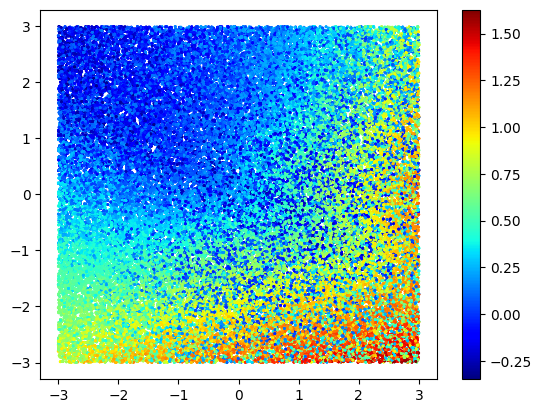

In [82]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Plot...
plt.scatter(X[:,0], X[:,1], c=y_pred, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()

In [108]:
env = DubinsCarEnv()
state = env.reset()
done = False
max_iter = 100
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, _ = env.state_action_step(state, a)
        estimate = forward(X=next_state, params=params)
        print('estimate', estimate, 'actual', reward)
        possible_actions.append(estimate[0])
        #possible_actions.append(reward)
    action = np.argmax(np.array(possible_actions))
    print(action, possible_actions )

    state, reward, done, _ = env.step(action)
    env.render()
    print(counter)
    
env.make_gif()

estimate [0.62972236] actual 0
estimate [0.6672629] actual 0
estimate [0.6843718] actual 0
2 [Array(0.62972236, dtype=float32), Array(0.6672629, dtype=float32), Array(0.6843718, dtype=float32)]
1
estimate [0.70775795] actual 0
estimate [0.7565421] actual 0
estimate [0.7046075] actual 0
1 [Array(0.70775795, dtype=float32), Array(0.7565421, dtype=float32), Array(0.7046075, dtype=float32)]
2
estimate [0.8276336] actual 0
estimate [0.87562096] actual 0
estimate [0.8917147] actual 0
2 [Array(0.8276336, dtype=float32), Array(0.87562096, dtype=float32), Array(0.8917147, dtype=float32)]
3
estimate [0.83544505] actual 0
estimate [0.86218035] actual 0
estimate [0.79875815] actual 0
1 [Array(0.83544505, dtype=float32), Array(0.86218035, dtype=float32), Array(0.79875815, dtype=float32)]
4
estimate [0.79526913] actual 0
estimate [0.8220043] actual 0
estimate [0.79613554] actual 0
1 [Array(0.79526913, dtype=float32), Array(0.8220043, dtype=float32), Array(0.79613554, dtype=float32)]
5
estimate [0.75

In [30]:
y_pred = [forward(X=x, params=params) for x in X]

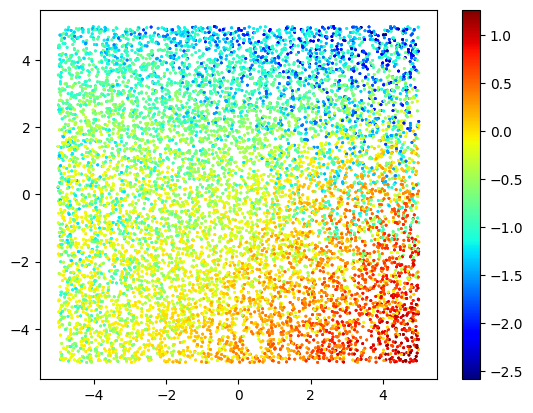